# Cryptocurrency Data Science Tutorial

## Data Collection and Curation
  When beginning a data analysis on anything, the first step is to find some data to work with. Often, data is not available for us to use in perfect form. This means that we must either find a way to get the data from the internet or clean the data to make it useable for ourselves. In our case, there is a database recording valueable information on crypto currencies online. We can simply download this database and use the information for ourselves. The database we used is located at: https://github.com/oknott14/data_host. The data is currently stored in a repository with each coin containing a seperate .csv file. Since seperated data is hard to work with, we must first compile these files into one large table. We will be using sqlite3 and the pandas python library for this project, but any database library will work.

  First, lets import all of our necessary libraries, and prepare the pytrends library for scraping Google Trends data

In [1]:
import pandas as pd
import sqlite3
from os import listdir
import requests as rq
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures as pf
from sklearn.pipeline import Pipeline
import datetime as dt
try:
  from pytrends.request import TrendReq
except:
  !pip install pytrends
  from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-us', tz=360)

Next, lets create our master table conntaining all of our crypto-currencies. For later use, we will format the date as a python datetime object and add a date key column.

In [2]:
#Clone directory and read files
path = '/content/data_host'
try:
  files = listdir(path)
except:
  !git clone https://github.com/oknott14/data_host 
  files = listdir(path)
files.remove('.git')
files.sort() 
sqlName = files.pop() #get sql db file name

#Connect to sql database
conn = sqlite3.connect(f"{path}/{sqlName}")

#Read Tables into sql
for file in files:
  tbl = pd.read_csv(f"{path}/{file}")
  tbl['DateKey'] = tbl['Date'].apply(lambda c: int(c[0:10].replace('-','')))
  cols = list(tbl.columns)
  cols.remove('SNo')
  tbl[cols].to_sql("Master",conn,if_exists='append',index=False)

frame = pd.read_sql("SELECT * FROM Master",conn)
frame.head()

,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,DateKey,Change
0,Aave,AAVE,2020-10-05 23:59:59,55.112358,49.787900,52.675035,53.219243,0.000000e+00,8.912813e+07,20201005,None
1,Aave,AAVE,2020-10-06 23:59:59,53.402270,40.734578,53.291969,42.401599,5.830915e+05,7.101144e+07,20201006,None
2,Aave,AAVE,2020-10-07 23:59:59,42.408314,35.970690,42.399947,40.083976,6.828342e+05,6.713004e+07,20201007,None
3,Aave,AAVE,2020-10-08 23:59:59,44.902511,36.696057,39.885262,43.764463,1.658817e+06,2.202651e+08,20201008,None
4,Aave,AAVE,2020-10-09 23:59:59,47.569533,43.291776,43.764463,46.817744,8.155377e+05,2.356322e+08,20201009,None


Now, lets scrape our data using the unique names from our SQL Database, and query Google Trends with these names. By grabbing the unique names and merging the dataframes we can create one dataframe almost ready to merge with our SQL dataframe. We will modify the data that pytrends gives us by creating a startDate and endDate column along with start and end date key columns. The two key columns will make it easier to locate dates within the week of search results.

In [4]:
query_names = frame['Name'].unique() # Shows us the unique Cryptocurrencies we have in the original dataset

trends_df = None

for i in range(0, len(query_names), 5):
  pytrends.build_payload(query_names[i: i + 5]) # Queries google trends a subsection of query_names, to later merge
  try:
    trends_df = trends_df.merge(pytrends.interest_over_time().drop(columns='isPartial'), left_index=True, right_index=True)
  except:
    trends_df = pytrends.interest_over_time().drop(columns=['isPartial'])
    pass

#Create start and end date columns with matching key columns
trends_df['endDate'] = trends_df.index
idt = trends_df.iloc[0,23].date()
trends_df['startDate'] = [pd.Timestamp(idt.year, idt.month, idt.day - 7)] + trends_df['endDate'].tolist()[:-1]
for val in ['end','start']:
  trends_df[f'{val}DateKey'] = trends_df[f'{val}Date'].apply(lambda c: int(c.date().strftime('%Y%m%d')))
trends_df.index = range(0,len(trends_df))
trends_df.to_sql("Trends",conn)
trends_df.head()

,Aave,Binance Coin,Bitcoin,Cardano,Chainlink,Cosmos,Crypto.com Coin,Dogecoin,EOS,Ethereum,IOTA,Litecoin,Monero,NEM,Polkadot,Solana,Stellar,Tether,TRON,USD Coin,Uniswap,Wrapped Bitcoin,XRP,endDate,startDate,endDateKey,startDateKey
0,0,0,2,0,0,4,0,0,6,1,1,0,0,19,1,4,6,3,40,0,0,0,0,2016-05-22,2016-05-15,20160522,20160515
1,0,0,3,0,0,3,0,0,6,1,1,0,0,20,0,4,6,3,39,0,0,0,0,2016-05-29,2016-05-22,20160529,20160522
2,0,0,3,0,0,3,0,0,6,1,1,0,0,21,0,4,7,3,39,0,0,0,0,2016-06-05,2016-05-29,20160605,20160529
3,0,0,4,0,0,3,0,0,6,2,1,1,0,21,0,4,6,3,35,0,0,0,0,2016-06-12,2016-06-05,20160612,20160605
4,0,0,4,0,0,3,0,0,7,1,1,0,0,23,0,4,6,3,38,0,0,0,0,2016-06-19,2016-06-12,20160619,20160612


## Data Management and Representation
The day to day trends can be hard to analyze with so many values. During our exploratory data analysis, we will want to quickly locate large fluctiations in the price of coins. To target these, we will create a monthly and yearly change table.

First, create a pandas data frame for our master table. We will use this data frame to create our two new tables since pandas makes it easy to modify and add data. To begin, we will create two new columns, Month and Year. These columns will replace the Date column in the additional tables. We will also remove the time portion of the date column.

In some cases, seperating the month and year from a combined date could be considered tidying our data. Data is considered messy when there is more than one value stored in a single column, more than one observation in each row, or more than one set of observations in a table. With tidy data, every row should correspond to a distince observation for each column. Our data in master and in the tables we are creating now will be tidy since every row has a unique set of values for the behavior of a given coin on a given date. If, for example, high and low were stored in one column, say high/low with the value 'high/low', this data would be messy. To tidy this data we would need to split high/low into the two columns by the '/' in the string. Then we can perform computations on the two values without extra steps. Another example would be having the data for every coin in one row corresponding to a date. For more information on tidying data, check out this link: https://towardsdatascience.com/whats-tidy-data-how-to-organize-messy-datasets-in-python-with-melt-and-pivotable-functions-5d52daa996c9

In [5]:
master = pd.read_sql("SELECT * FROM Master",conn)
master['Year'] = master['Date'].apply(lambda c: c[0:4])
master['Month'] = master['Date'].apply(lambda c: c[0:7])
master['Date'] = master['Date'].apply(lambda c: c[0:10])

Now that we have our data ready in pandas, we will use the groupby function to add each unique Year and Month with their respective Name and Symbol values. This will give us a base values that we can merge future columns with.

In [6]:
tableVals = ['Year','Month']
newTables = [None,None]

for idx in range(0,2):
  newTables[idx] = master[[tableVals[idx],'Name','Symbol']].groupby([tableVals[idx],'Name','Symbol'], as_index=False).min()
  
newTables[0].head()

,Year,Name,Symbol
0,2013,Bitcoin,BTC
1,2013,Dogecoin,DOGE
2,2013,Litecoin,LTC
3,2013,XRP,XRP
4,2014,Bitcoin,BTC


Now that we have our base values, lets merge the rest of the columns into our database. For high and low we can use groupby and merge to add the max and min values from each time period. Open and close is a little more complicated. We must use the max and min values for the Date for both month and year, since some coins were created in the middle of year or the month. Finally for Volume and Marketcap we can use the median values to represent the average among each year. Finally, we will also add a start and end column and two matching key columns to the data tables.

In [7]:
for idx in range (0,2):
  #Add start and end date coluns
  newTables[idx]['startDate'] = newTables[idx].merge(master[[tableVals[idx],'Name','Date']].groupby([tableVals[idx],'Name'],as_index=False).min(),'inner')['Date']
  newTables[idx]['endDate'] = newTables[idx].merge(master[[tableVals[idx],'Name','Date']].groupby([tableVals[idx],'Name'],as_index=False).max(),'inner')['Date']
  #Add start and end date key columns
  newTables[idx]['startDateKey'] = newTables[idx]['startDate'].apply(lambda c: int(c.replace('-','')))
  newTables[idx]['endDateKey'] = newTables[idx]['endDate'].apply(lambda c: int(c.replace('-','')))
  #Add High Column with merge
  newTables[idx] = newTables[idx].merge(
      master[[tableVals[idx],'Name','High']].groupby([tableVals[idx],'Name'], as_index=False).max(),
      'inner')
  #Add Low Column with merge
  newTables[idx] = newTables[idx].merge(
      master[[tableVals[idx],'Name','Low']].groupby([tableVals[idx],'Name'], as_index=False).min(),
      'inner')
  #Add Open Column with merge
  openTbl = master[[tableVals[idx],'Name','Date']].groupby(
      [tableVals[idx],'Name'],as_index=False).min().merge(
          master[[tableVals[idx],'Name','Open','Date']],'left')
  newTables[idx] = newTables[idx].merge(openTbl[[tableVals[idx],'Name','Open']],'inner')
  #Add Close Column with merge
  closeTbl = master[[tableVals[idx],'Name','Date']].groupby(
      [tableVals[idx],'Name'],as_index=False).max().merge(
          master[[tableVals[idx],'Name','Close','Date']],'left')
  newTables[idx] = newTables[idx].merge(closeTbl[[tableVals[idx],'Name','Close']],'inner')
  #Add Average Volume  and Marketcap with merge
  for col in ['Volume','Marketcap']:
    newTables[idx] = newTables[idx].merge(master[[tableVals[idx],'Name',col]].groupby([tableVals[idx],'Name'],as_index=False).mean(),'inner')
    newTables[idx] = newTables[idx].rename(columns={col:f"Avg{col}"})

newTables[0].head()

,Year,Name,Symbol,startDate,endDate,startDateKey,endDateKey,High,Low,Open,Close,AvgVolume,AvgMarketcap
0,2013,Bitcoin,BTC,2013-04-29,2013-12-31,20130429,20131231,1156.140015,65.526001,134.444,754.01001,566740.080972,3.066581e+09
1,2013,Bitcoin,BTC,2013-04-29,2013-12-31,20130429,20131231,1156.140015,65.526001,134.444,754.01001,566740.080972,3.066581e+09
2,2013,Bitcoin,BTC,2013-04-29,2013-12-31,20130429,20131231,1156.140015,65.526001,134.444,754.01001,566740.080972,3.066581e+09
3,2013,Bitcoin,BTC,2013-04-29,2013-12-31,20130429,20131231,1156.140015,65.526001,134.444,754.01001,566740.080972,3.066581e+09
4,2013,Bitcoin,BTC,2013-04-29,2013-12-31,20130429,20131231,1156.140015,65.526001,134.444,754.01001,566740.080972,3.066581e+09


Finally, lets add our tables to our sql database with the pandas to_sql function.

In [8]:
for idx in range(0,2):
  try:
    newTables[idx].to_sql(f"{tableVals[idx]}lyChange", conn)
  except:
    print(f"Table {tableVals[idx]}lyChange Already Exists")

Table YearlyChange Already Exists
Table MonthlyChange Already Exists


Now that we have all of our tables, there is one more column we want to add. All of the numerical data provided is great, but it is not enough for a financial analysis of the crypto-currency's performances. We will need to compute the percent change for each day. The formula is as follows:

> % Change = (Close - Open) / Close

This value shows how much the crypto-currency rose or fell over the given time period. This will be useful for later analysis, where we will want to see what the return on investment will be for certain coins over time.

In [9]:
cur = conn.cursor()

tables = [x[0] for x in cur.execute("SELECT name FROM sqlite_master WHERE type='table' AND name!='Trends'").fetchall()]
for table in tables:
  #Add Change column if there is not one
  if (not ('Change',) in cur.execute(f"SELECT name FROM PRAGMA_TABLE_INFO('{table}')").fetchall())  :
    cur.execute(f"ALTER TABLE {table} ADD COLUMN Change REAL")
  #Set Change values if theyre Null
  if (cur.execute(f"SELECT SUM(Change) FROM {table}").fetchone()[0] == None):
    cur.execute(f"UPDATE {table} SET Change = (Close - Open) / Close")
cur.close()

pd.read_sql("SELECT * FROM Master",conn).head()

,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,DateKey,Change
0,Aave,AAVE,2020-10-05 23:59:59,55.112358,49.787900,52.675035,53.219243,0.000000e+00,8.912813e+07,20201005,0.010226
1,Aave,AAVE,2020-10-06 23:59:59,53.402270,40.734578,53.291969,42.401599,5.830915e+05,7.101144e+07,20201006,-0.256839
2,Aave,AAVE,2020-10-07 23:59:59,42.408314,35.970690,42.399947,40.083976,6.828342e+05,6.713004e+07,20201007,-0.057778
3,Aave,AAVE,2020-10-08 23:59:59,44.902511,36.696057,39.885262,43.764463,1.658817e+06,2.202651e+08,20201008,0.088638
4,Aave,AAVE,2020-10-09 23:59:59,47.569533,43.291776,43.764463,46.817744,8.155377e+05,2.356322e+08,20201009,0.065216


## Exploratory Data Analysis
Now that we have our data stored correctly, lets see what information it might tell us. To bein, we will try to see what type of function might predict the behavior of a crypto currency the best. To tackle this, we wil compute linear regressions on the data for lines and polynomials. To see how well the model predicts the future, we will start by fitting it to about 70% of our data. The other 30% of data will be used to test the prediction. We will use the sci-kit learn LinearRegression and Polynomial 

In [10]:
#Linear Regression On the whole market
cur = conn.cursor()

model = Pipeline([('poly',pf(degree=4)), ('linear',LinearRegression(fit_intercept=False))])
cur.close()

In [ ]:
#Multiple degree regression...

cur = conn.cursor()
coins = ['Bitcoin'] #[x[0] for x in cur.execute(f"SELECT DISTINCT Name FROM {table}").fetchall()]
coinRegs = {}
for coin in coins:
  X = [[1.,float(x[0].replace('-',''))] for x in cur.execute(f"SELECT {xVal} FROM {table} WHERE Name = '{coin}'").fetchall()]
  y = [float(x[0]) for x in cur.execute(f"SELECT Close FROM {table} WHERE Name = '{coin}'").fetchall()]
  model.fit(X,y)
  coinRegs[coin] = model.fit(X,y)
  print(f"{coin}: {coinRegs[coin].named_steps['linear'].coef_}")
cur.close()


In [ ]:
btc = coinRegs['Bitcoin']
df = pd.read_sql("SELECT * FROM MonthlyChange WHERE Name = 'Bitcoin'", conn)
df['pred'] = df['Month'].apply(lambda c: btc.predict([[1.,float(c.replace('-',''))]])[0])
df.head()

ax = df.plot(x='Month',y='Close',kind='scatter')
df.plot(x='Month',y='pred',ax=ax)
print(df['Close'].tolist())

Now, lets try and plot the High data for one crypto currency versus the trends data, and see if there is a relationship. First we need to conver them both to months, and collect their data to plot.

95
95


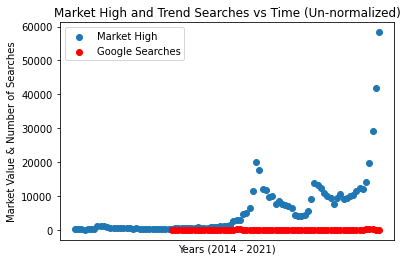

In [13]:
import matplotlib.pyplot as plt

monthly_high = pd.read_sql("SELECT Name, High, Month FROM MonthlyChange",conn)
months = []
for month in monthly_high['Month']:
  months.append(month.replace('-', ''))
monthly_high['MonthKey'] = months
model = LinearRegression().fit(monthly_high['MonthKey'][monthly_high['Name'] == 'Bitcoin'].values.reshape(-1, 1), 
                               monthly_high['High'][monthly_high['Name'] == 'Bitcoin'].values.reshape(-1, 1))

trends = []
i = 1
temp = 0.
for weeks in trends_df['Bitcoin']:
  if i == 4:
    trends.append(temp)
    i = 1
    temp = 0. 
  else:
    temp += weeks
    i = i + 1

months = monthly_high['MonthKey'][monthly_high['Name'] == 'Bitcoin']
trends_months = months[len(months) - len(trends):]
high_data = monthly_high['High'][monthly_high['Name'] == 'Bitcoin']

print(len(months))
print(len(high_data))

plt.scatter(months, high_data)
plt.scatter(trends_months, trends, color='red')
plt.legend(labels=['Market High', 'Google Searches'])
plt.title('Market High and Trend Searches vs Time (Un-normalized)')
plt.ylabel('Market Value & Number of Searches')
plt.xticks(ticks=[])
plt.xlabel('Years (2014 - 2021)')
plt.show()

As we can see, most values in the trends data is ranging 0-100, meaning when placed next to data in the thousands, we can not see any relationship, because the trends data is so small. The solution of this is to normalize both datasets by dividing each value in each dataset by their datasets maximum value. That is what we do below.

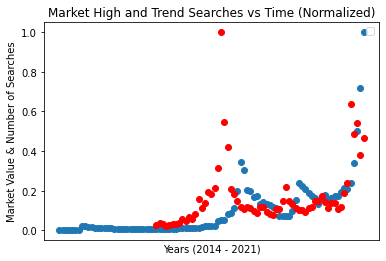

In [14]:
# Normalize the data and look for trends again

max_high = max(high_data)
max_trend = max(trends)

norm_high_data = []
for v in high_data:
  norm_high_data.append(float(v) / max_high)

for ind, v in enumerate(trends):
  trends[ind] = float(v) / max_trend

plt.legend(labels=['Market High', 'Google Searches'])
plt.title('Market High and Trend Searches vs Time (Normalized)')
plt.ylabel('Market Value & Number of Searches')
plt.xticks(ticks=[])
plt.xlabel('Years (2014 - 2021)')
plt.scatter(months, norm_high_data)
plt.scatter(trends_months, trends, color='red')
plt.show()

As we can see now, there does seem to be some trend in market value and Google search trends. It appears that when the trends data spikes, a spike in market high value is imminent. This indicates that Google's trends data might just be a good indicator of stock price value, but one example is not enough to say for sure.

## Hypothesis Testing, Supervised Learning
With this data, we can create a Linear based sin regression based on the trend data, that predicts the high price. So we take the trends data as input, the market value as output and train a model to predict the high price given trends data. Training our model on Bitcoin, we can then test the models performance on another coin, for instance Dogecoin.

Accuracy for training data (self accuracy): nan


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


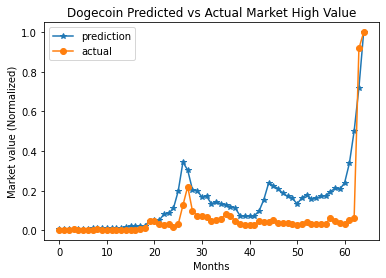

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Create our training data on Bitcoin
train_trends_input = []
train_high_label = []

# Convert trends data of Bitcoin to an array of Monthly totals
i = 1
temp = 0.
for weeks in trends_df['Bitcoin']:
  if i == 4:
    train_trends_input.append(temp)
    i = 1
    temp = 0. 
  else:
    temp += weeks
    i = i + 1

# Grab the high data from the table, and only relevant months
train_high_label = monthly_high['High'][monthly_high['Name'] == 'Bitcoin']
train_high_label = train_high_label[len(train_high_label) - len(train_trends_input):]

# Get the maximums of both lists for normalization
max_high = max(train_high_label)
max_trend = max(train_trends_input)

norm_X = []
norm_y = []

# Normalize both lists
for ind, v in enumerate(train_high_label):
  norm_y.append(v / max_high)

for ind, v in enumerate(train_trends_input):
  norm_X.append(v / max_trend)

# Create test data using Dogecoin, same process as above
train_trends_input = []
train_high_label = []

# Convert trends data of Dogecoin to an array of Monthly totals
i = 1
temp = 0.
for weeks in trends_df['Dogecoin']:
  if i == 4:
    train_trends_input.append(temp)
    i = 1
    temp = 0. 
  else:
    temp += weeks
    i = i + 1

# Grab the high data from the table, and only relevant months
train_high_label = monthly_high['High'][monthly_high['Name'] == 'Dogecoin']
train_high_label = train_high_label[len(train_high_label) - len(train_trends_input):]

# Get maximums for normalization
max_high = max(train_high_label)
max_trend = max(train_trends_input)

norm_X_test = []
norm_y_test = []

# Normalize to push data to [0, 1]
for ind, v in enumerate(train_high_label):
  norm_y_test.append(v / max_high)

for ind, v in enumerate(train_trends_input):
  norm_X_test.append(v / max_trend)

# training using Bitcoin data
regressor = LinearRegression()
regressor.fit([norm_X], [norm_y]) # fit the model for training data

# predict the target given the trends data
prediction_training_targets = regressor.predict([norm_X])

# Compute Accuracy scores
self_accuracy = regressor.score([norm_X], [norm_y])
print("Accuracy for training data (self accuracy):", self_accuracy)

# Use model to predict on test data
prediction_test_targets = regressor.predict([norm_X_test])

# plot the predicted and actual target for test data
plt.plot(np.squeeze(prediction_test_targets), '-*')
plt.plot(norm_y_test, '-o' )
plt.legend(['prediction', 'actual'])
plt.title('Dogecoin Predicted vs Actual Market High Value')
plt.ylabel('Market value (Normalized)')
plt.xlabel('Months')
plt.show()


## Final Results/Findings
What we have found from our Regression is a model that appears to predict a higher value than what is typically the market output. That being said, it does tend to increase prior to the market value actually increasing, which could be a useful model for making money. That being said, we could also take this model further, by training it on more data, and potentially decreasing the complexity, or hyperfocusing on the volatile sections, however for this case our model is good. It does seem though, that there is one occurence where our model predicts a spike that does not occur in the market data. So, there are flaws, but certainly hope.